TODO: print scatter plot,
as in https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

also, it seems that I do not need to use ranks to compute spearman r

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [2]:
from thesis_v2 import dir_dict
from os.path import join

import pandas as pd
import numpy as np

In [3]:
metric_pkl_loc_k_bl = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218.pkl'
)

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    keygen
)

In [5]:
df_all_k_bl = pd.read_pickle(metric_pkl_loc_k_bl)
# only on test subset
df_all_k_bl = df_all_k_bl.xs('test', level='subset')

In [6]:
def find_sensitive_neurons(series_this, measure, cls_level, baseline_key, improved_key):
    # series_this should be generated by `df_all.xs(...).xs(...)...['val_per']
    
    # base line is performance at rcnn_bl_cls=2
    # improved is performance at rcnn_bl_cls=4 
    # (
    #     or maybe rcnn_bl_cls=3 then /2? 
    # )
    # but I think it's fine, because we have so many models to average out these issues.

    baseline_perf = series_this.xs(key=baseline_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    
    if isinstance(improved_key, int):
        improved_perf = series_this.xs(key=improved_key, level=cls_level).xs(key=measure,level='measure').sort_index()
    else:
        # then summing all together.
        improved_perf = series_this.xs(key=improved_key[0], level=cls_level).xs(key=measure,level='measure').sort_index()
        
        for improved_key_this in improved_key[1:]:
            improved_perf = improved_perf + series_this.xs(key=improved_key_this, level=cls_level).xs(key=measure,level='measure').sort_index()
        
        # all addition and division will work at numpy array level
        improved_perf = improved_perf/len(improved_key)

    assert baseline_perf.index.equals(improved_perf.index)
    
    num_neuron = 79
    
    data = pd.DataFrame({
        'baseline': baseline_perf,
        'improved': improved_perf,
    })
    
    delta_all = np.zeros((num_neuron,), dtype=np.float64)
    bad_case_count = np.zeros((num_neuron,), dtype=np.int64)
    good_case_count = np.zeros((num_neuron,), dtype=np.int64)
    all_case_count = 0
    
    for (k, v) in data.iterrows():
        
        assert isinstance(v['baseline'], np.ndarray)
        assert isinstance(v['improved'], np.ndarray)
        assert v['baseline'].shape == (num_neuron,)
        assert v['improved'].shape == (num_neuron,)
    
        # compute perf gain.
        delta_this = (v['improved'] - v['baseline'])/v['baseline']
        mask_this = v['baseline']!=0
        bad_case_count += np.logical_not(mask_this).astype(np.int64)
        good_case_count += mask_this.astype(np.int64)
        delta_all[mask_this] += delta_this[mask_this]
        all_case_count += num_neuron
        
    
    delta_all /= good_case_count
    print(all_case_count, bad_case_count.sum(), good_case_count.sum(), bad_case_count.sum()/all_case_count)
    return delta_all

In [7]:
from scipy.stats import spearmanr

In [8]:
def plot_scatter(x,y,xlabel,ylabel,title):
    assert x.shape == y.shape
    assert x.ndim == 1
    plt.close('all')
    plt.figure()
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [9]:
def gen_rank(array_this, reverse):
    assert array_this.ndim == 1
    temp = array_this.argsort()
    if reverse:
        temp = temp[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(array_this.size)
    return ranks

def find_sensitive_neurons_wrapper(series_this, cls_level, baseline_key, improved_key, plot=False):
    # using normed or normed does not matter, as that does not affect detla at all.
    delta_mse = find_sensitive_neurons(series_this, 'mse_normed', cls_level, baseline_key, improved_key)
    delta_cc2 = find_sensitive_neurons(series_this, 'cc2_normed', cls_level, baseline_key, improved_key)
    delta_cc = find_sensitive_neurons(series_this, 'cc_normed', cls_level, baseline_key, improved_key)
    
    # create rank for each of them
    # https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice/
    
    # smaller the better,
    rank_mse = gen_rank(delta_mse, reverse=False)
    # bigger better.
    rank_cc = gen_rank(delta_cc, reverse=True)
    # bigger better
    rank_cc2 = gen_rank(delta_cc2, reverse=True)
    
    rank_avg = gen_rank(np.mean([rank_mse, rank_cc, rank_cc2], axis=0), reverse=False)
    
    spear_mse_cc = spearmanr(rank_mse, rank_cc)[0]
    spear_cc_cc2 = spearmanr(rank_cc, rank_cc2)[0]
    spear_mse_cc2 = spearmanr(rank_mse, rank_cc2)[0]
    
    spear_mse_avg = spearmanr(rank_mse, rank_avg)[0]
    spear_cc_avg = spearmanr(rank_cc, rank_avg)[0]
    spear_cc2_vag = spearmanr(rank_cc2, rank_avg)[0]
    
    # let's plot these scatter plots.
    if plot:
        plot_scatter(rank_mse, rank_cc, 'mse rank', 'cc rank', f'cc vs mse {spear_mse_cc}')
        plot_scatter(rank_cc, rank_cc2, 'cc rank', 'cc2 rank', f'cc2 vs cc {spear_cc_cc2}')
        plot_scatter(rank_mse, rank_cc2, 'mse rank', 'cc2 rank', f'cc2 vs mse {spear_mse_cc2}')
        plot_scatter(rank_mse, rank_avg, 'mse rank', 'avg rank', f'avg vs mse {spear_mse_avg}')
        plot_scatter(rank_cc, rank_avg, 'mse rank', 'avg rank', f'avg vs cc {spear_cc_avg}')
        plot_scatter(rank_cc2, rank_avg, 'mse rank', 'avg rank', f'avg vs cc2 {spear_cc2_vag}')
    
    print(spear_mse_cc, spear_cc_cc2, spear_mse_cc2, spear_mse_avg, spear_cc_avg, spear_cc2_vag)
    
    
    
    return {
        'mse': rank_mse,
        'cc': rank_cc,
        'cc2': rank_cc2,
        'avg': rank_avg,
        'delta_mse': delta_mse,
        'delta_cc2': delta_cc2,
        'delta_cc': delta_cc,
    }

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0


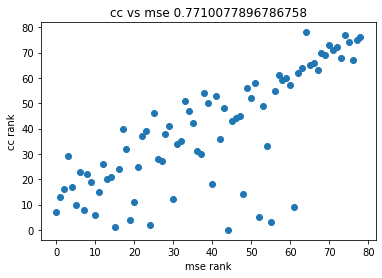

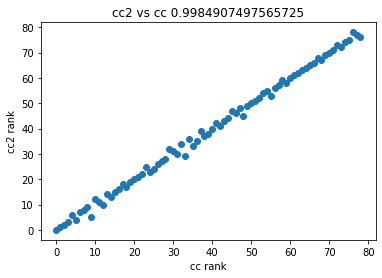

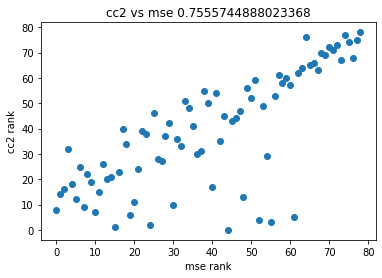

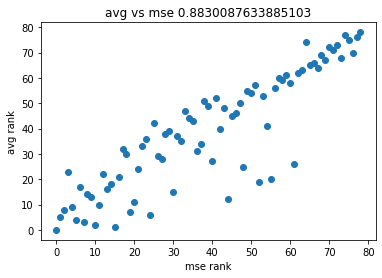

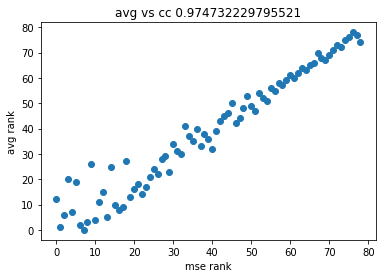

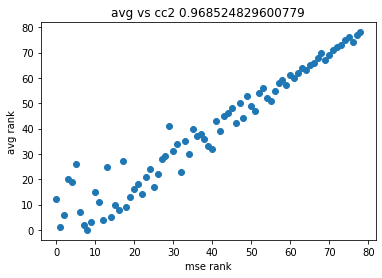

0.7710077896786758 0.9984907497565725 0.7555744888023368 0.8830087633885103 0.974732229795521 0.968524829600779


{'mse': array([54, 35, 51,  0, 60, 23, 72,  8, 57, 76,  6, 68, 13, 71, 33, 49, 73,
        12, 22, 17, 36, 28, 15, 55,  3,  9, 29, 40,  1, 11, 30, 69, 26, 16,
        38, 75, 62, 43, 47, 65, 46, 41, 74, 70, 34, 37, 77, 19, 24, 61, 59,
        42, 27,  2, 56, 48,  4, 66, 53, 14, 67, 78, 32, 18, 50, 45, 25, 31,
        58, 64, 63,  7, 10, 52, 44, 39, 21, 20,  5]),
 'cc': array([33, 42, 58,  7, 57, 39, 72, 22, 61, 67, 23, 70, 20, 71, 51, 56, 68,
        26, 37, 40, 31, 38,  1,  3, 29, 19, 41, 18, 13, 15, 12, 69, 28, 24,
        54, 74, 62, 48, 45, 65, 44, 53, 77, 73, 47, 30, 75,  4,  2,  9, 60,
        36, 27, 16, 55, 14, 17, 66, 49, 21, 63, 76, 35, 32, 52, 43, 46, 34,
        59, 78, 64,  8,  6,  5,  0, 50, 25, 11, 10]),
 'cc2': array([29, 41, 59,  8, 57, 38, 73, 22, 61, 68, 25, 70, 20, 71, 51, 56, 67,
        26, 39, 40, 30, 37,  1,  3, 32, 19, 42, 17, 14, 15, 10, 69, 28, 23,
        55, 74, 62, 45, 47, 65, 44, 54, 77, 72, 48, 31, 75,  6,  2,  5, 60,
        35, 27, 16, 53, 13, 18, 66, 

In [10]:
rank_dict_to_use_k_bl = find_sensitive_neurons_wrapper(df_all_k_bl['val_per'], 'rcnn_bl_cls', 2, 4, plot=True)
rank_dict_to_use_k_bl

In [11]:
dummy = find_sensitive_neurons_wrapper(df_all_k_bl['val_per'], 'rcnn_bl_cls', 2, [3,4])

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.7090555014605647 0.9968841285296982 0.6860029211295035 0.8416017526777021 0.9703748782862708 0.9618062317429407


In [12]:
metric_pkl_loc_pcn = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_local_pcn+certain_configs.pkl'
)

df_all_pcn = pd.read_pickle(metric_pkl_loc_pcn)

df_all_pcn = df_all_pcn.xs('test', level='subset')

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0


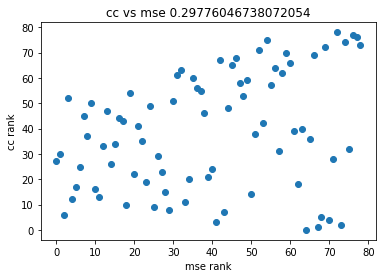

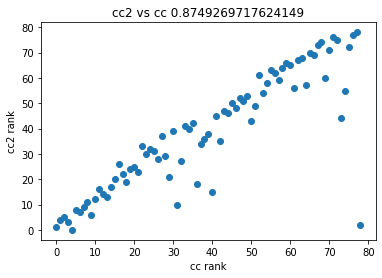

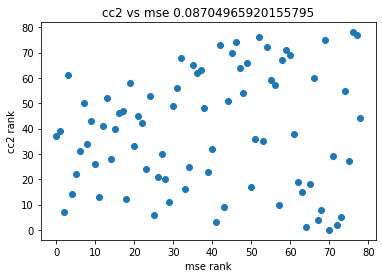

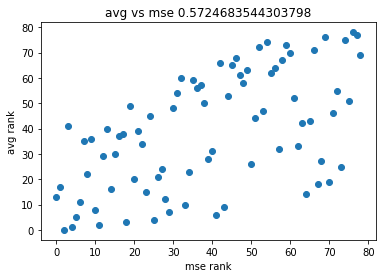

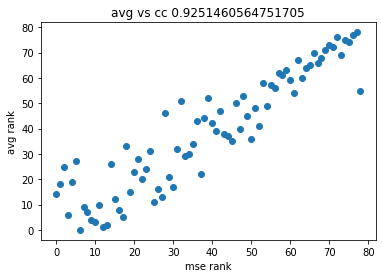

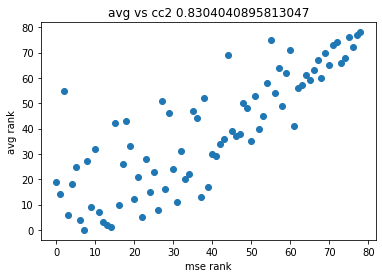

0.29776046738072054 0.8749269717624149 0.08704965920155795 0.5724683544303798 0.9251460564751705 0.8304040895813047


In [13]:
# bad consistency, not study it.
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, (2,3,4,5), plot=True)

In [14]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 3)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.35107108081791627 0.8829113924050633 0.13770691333982474 0.6091041869522883 0.9284079844206428 0.8339094449853944


In [15]:
rank_dict_to_use_pcn = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 2)
rank_dict_to_use_pcn

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.45384615384615384 0.8879746835443038 0.2687439143135346 0.6596884128529699 0.9453018500486856 0.8661879259980526


{'mse': array([46, 32,  9,  0, 26, 30, 74, 19, 27, 73, 67, 78,  4, 70, 23, 33, 34,
        22, 12,  5, 40, 16, 21, 59,  7, 36, 29, 58,  2, 51, 57, 49, 56, 17,
         8, 31, 76,  1, 45, 39, 25, 69, 52, 60,  3, 24, 75, 18, 50, 53, 35,
        14, 48,  6, 65, 68, 15, 71, 28, 13, 55, 77, 64, 66, 54, 43, 42, 41,
        38, 63, 62, 72, 20, 47, 61, 37, 10, 44, 11]),
 'cc': array([14, 23, 46, 29, 25,  4, 76, 42, 11, 68, 66, 77, 10, 69, 32, 57, 24,
        60, 35, 33, 56, 31,  5,  1, 52, 53, 27, 65, 30, 59, 18, 39, 64, 51,
        17, 13, 62,  7, 54, 37, 21, 75, 34, 70, 20, 40, 71,  8,  3,  6, 48,
        12, 47, 41, 67, 15, 38, 28, 55, 43, 26, 74,  9, 73, 63, 19, 44, 58,
        45, 78, 61, 72, 16,  2,  0, 49, 22, 50, 36]),
 'cc2': array([17, 26, 53, 33, 28,  2, 74, 45,  7, 71, 47, 78, 12, 64, 31, 68, 21,
        69, 41, 38, 65, 37, 10,  1, 63, 60, 29, 54, 36, 66, 19, 35, 56, 59,
        16, 11, 49,  8, 61, 32, 25, 77, 30, 72, 24, 44, 75, 14,  5,  9, 52,
        18, 42, 48, 58, 20, 39, 23, 

In [16]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 4)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.38186465433300876 0.8805014605647518 0.1702775073028238 0.6358812074001948 0.9323271665043817 0.8365384615384616


In [17]:
dummy = find_sensitive_neurons_wrapper(df_all_pcn['val_per'], 'pcn_cls', 1, 5)

30336 0 30336 0.0
30336 0 30336 0.0
30336 0 30336 0.0
0.34532619279454724 0.862682570593963 0.11755111976630965 0.6090555014605649 0.9217380720545278 0.8213729308666019


In [18]:
# given above results, we should analyze top ranking neurons in k_bl, which gives more consistent ranking.

# it's interesting that actually the ranking between two models are not that related.

In [19]:
spearmanr(
    rank_dict_to_use_pcn['avg'],
    rank_dict_to_use_k_bl['avg']
)

SpearmanrResult(correlation=0.363510223953262, pvalue=0.0009917032960917668)

In [20]:
# ok. then study those 

[-3.71926271 -1.74527224 -1.50144999 -1.45700441 -1.40500885 -1.35834116
 -1.32763303 -1.20166916 -1.16888126 -1.12274589]


array([ 3, 28, 53, 24, 56, 78, 10, 71,  7, 25, 72, 29, 17, 12, 59, 22, 33,
       19, 63, 47, 77, 76, 18,  5, 48, 66, 32, 52, 21, 26, 30, 67, 62, 14,
       44,  1, 20, 45, 34, 75, 27, 41, 51, 37, 74, 65, 40, 38, 55, 15, 64,
        2, 73, 58,  0, 23, 54,  8, 68, 50,  4, 49, 36, 70, 69, 39, 57, 60,
       11, 31, 43, 13,  6, 16, 42, 35,  9, 46, 61])

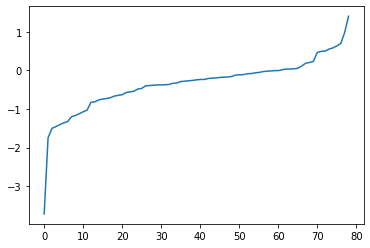

In [21]:
plt.plot(rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['mse'])]*100)
print((rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['mse'])]*100)[:10])
np.argsort(rank_dict_to_use_k_bl['mse'])

[-3.71926271 -0.74289917 -1.07086465 -1.20166916 -1.35834116 -1.74527224
 -0.48279469 -0.64413648 -1.50144999 -1.40500885]


array([ 3, 22, 72, 71, 78, 28, 48, 47, 53, 56, 29, 77, 74, 25,  7, 30, 12,
       10, 59, 73, 23, 33, 17, 24, 76, 55, 49, 27, 52, 32, 63, 20, 19, 18,
       45, 62,  5, 67, 21, 26, 51,  0, 66,  1, 44, 65, 40, 14, 37, 75, 38,
       34, 41, 58, 64, 15, 54,  2,  4, 68,  8, 50, 36, 70, 60, 39, 57, 31,
       16, 11,  9, 13, 43,  6, 69, 35, 46, 42, 61])

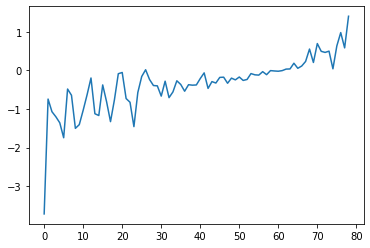

In [22]:
plt.plot(rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['avg'])]*100)
print((rank_dict_to_use_k_bl['delta_mse'][np.argsort(rank_dict_to_use_k_bl['avg'])]*100)[:10])
np.argsort(rank_dict_to_use_k_bl['avg'])

In [23]:
# neuron 3 (0-indexed) has best improvement. probably let's also study neuron 71.

from thesis_v2.data.prepared.yuanyuan_8k import get_data

def get_all_data_for_related_neurons(specific_neuron_list):
    dir_response = join(
        dir_dict['analyses'],
        'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218'
    )
    param_list = []
    resp_all = []
    for idx, param in enumerate(param_iterator_obj().generate()):
        
        assert len(param) == 22
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        assert param['rcnn_acc_type'] == 'cummean'
        
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
#         print(key)
        
        file_to_load_this = join(dir_response, key, 'test' + '.npy')
        
        resp = np.load(file_to_load_this)
        assert resp.shape == (1600, 79)
        resp = resp[:, specific_neuron_list]
        assert resp.shape == (1600, len(specific_neuron_list))
        param_list.append(param)
        resp_all.append(resp)
    
    resp_all = np.asarray(resp_all)
    
    return param_list, resp_all
    

def study_specific_neurons():
    specific_neuron_list = [3, 71]
    
    
    
    base_key = 2
    improved_key = 4
    for n_idx in specific_neuron_list:
        series_this = df_all_k_bl['val_per'].apply(lambda x: x[n_idx])
        # get it's metrics.
        
        
        for measure in ('mse', 'cc', 'cc2'):
            baseline_perf = series_this.xs(
                key=base_key, level='rcnn_bl_cls'
            ).xs(
                key=measure, level='measure'
            ).sort_index()

            improved_perf = series_this.xs(
                key=improved_key, level='rcnn_bl_cls'
            ).xs(
                key=measure, level='measure'
            ).sort_index()

            assert baseline_perf.index.equals(improved_perf.index)

            print(n_idx, measure,
                  baseline_perf.values.mean(),
                  improved_perf.values.mean(),
                  (improved_perf.values.mean()-baseline_perf.values.mean())/baseline_perf.values.mean()*100
                 )
    
    # ok. time to get the responses for all these neurons.
    param_list, resp_all = get_all_data_for_related_neurons(specific_neuron_list)
    print(resp_all.shape)
    
    # let's check the numbers obtained above, again.
    baseline_resp = resp_all[[i for i, z in enumerate(param_list) if z['rcnn_bl_cls'] == base_key]]
    improved_resp = resp_all[[i for i, z in enumerate(param_list) if z['rcnn_bl_cls'] == improved_key]]
    
    
    # load ground truth response.
    data_gt = get_data('a', 200, 50,
             ('042318', '043018', '051018'),
             scale=0.5,
             seed='legacy')[5]
    assert data_gt.shape == (1600, 79)
    data_gt_subset = data_gt[:,specific_neuron_list]
    assert data_gt_subset.shape == (1600, len(specific_neuron_list))
#     datasets = get_data_cached(param['input_size'], param['split_seed'])


#         datasets = {
#             'X_train': datasets[0].astype(np.float32),
#             'y_train': datasets[1],
#             'X_val': datasets[2].astype(np.float32),
#             'y_val': datasets[3],
#             'X_test': datasets[4].astype(np.float32),
#             'y_test': datasets[5],
#         }
    
    
    assert baseline_resp.shape == improved_resp.shape
    for n_idx_idx, n_idx in enumerate(specific_neuron_list):
        baseline_resp_this = baseline_resp[:,:,n_idx_idx]
        improved_resp_this = improved_resp[:,:,n_idx_idx]
        gt_this = data_gt_subset[:,n_idx_idx]
        
        se_per_img_baseline = (gt_this - baseline_resp_this)**2
        se_per_img_improved = (gt_this - improved_resp_this)**2
        
        mse_baseline = se_per_img_baseline.mean()
        mse_improved = se_per_img_improved.mean()
        
        # match what's above.
        print(n_idx, 'mse', mse_baseline, mse_improved, (mse_improved-mse_baseline)/mse_baseline*100)
        
        # time to check per image result.
        se_per_img_baseline_across_config = se_per_img_baseline.mean(axis=0)
        se_per_img_improved_across_config = se_per_img_improved.mean(axis=0)
        assert se_per_img_improved_across_config.shape == se_per_img_baseline_across_config.shape == (1600,)
        
        # let's plot something, like what I plot for errors.
        # hope that we can find some images with consistently lower errors.
        
        delta_per_img =  (se_per_img_improved_across_config-se_per_img_baseline_across_config)
        img_arg_sort = np.argsort(delta_per_img)
        delta_per_img_sorted = delta_per_img[img_arg_sort]
        plt.close('all')
        plt.plot(delta_per_img_sorted)
        plt.show()
        
        
        
        print(delta_per_img_sorted[:10]*100)
        
        plt.close('all')
        plt.plot(delta_per_img_sorted[:100])
        plt.show()
        print(delta_per_img_sorted[-10:]*100)
        
        plt.close('all')
        plt.plot(delta_per_img_sorted[-100:])
        plt.show()
        
        print(img_arg_sort[:20])
        print(img_arg_sort[-20:])

3 mse 0.00892429181763111 0.008580933471177324 -3.8474576299201306
3 cc 0.7181464745259194 0.7313461674261278 1.8380223768308688
3 cc2 0.5163469913902053 0.535410437996871 3.691983670775257
71 mse 0.6817333908839212 0.6733281932705261 -1.2329156420660408
71 cc 0.49453307156847776 0.5028782118118434 1.6874786992299546
71 cc2 0.24489047601660138 0.25319327993244656 3.3904151973971905
(1536, 1600, 2)
3 mse 0.00892429181763111 0.008580933471177322 -3.84745762992015


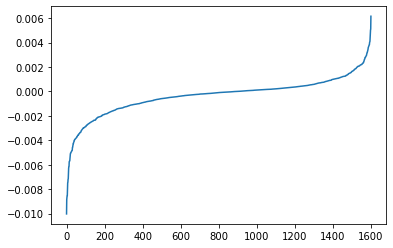

[-1.00210791 -0.88479988 -0.86345084 -0.85348164 -0.85275137 -0.79157015
 -0.74798581 -0.74251055 -0.71903482 -0.71474695]


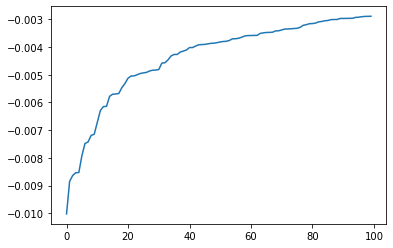

[0.38105434 0.38199069 0.39997877 0.40455358 0.41102082 0.44388135
 0.49104836 0.5033557  0.51071185 0.61602831]


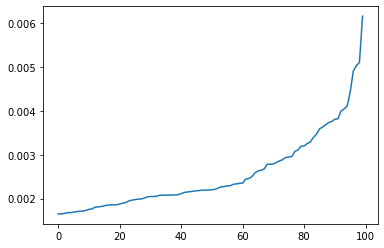

[ 942   42 1389  211  824  714  668  141  648  728  767   98 1047  156
 1556  798 1502 1348  637  178]
[1419   33   19 1288  153  106  431 1583 1045  131  585  542   28  770
 1373  554  325 1073  319 1582]
71 mse 0.6817333908839205 0.6733281932705254 -1.2329156420660419


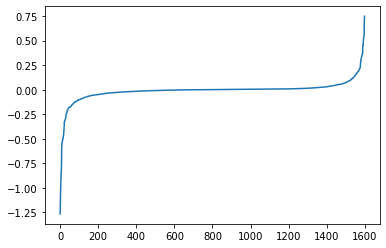

[-126.54340921 -111.61166821 -105.23174741  -95.39851607  -91.28729463
  -87.17773157  -81.98133082  -77.39224773  -60.63088828  -55.11021726]


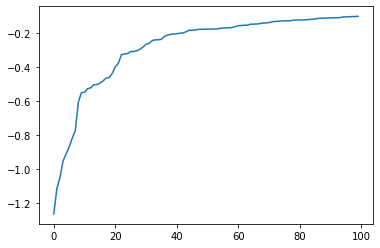

[44.65038399 45.63631681 45.65245632 51.08038342 51.72831205 53.0187217
 53.89597688 56.23442216 70.98615754 74.86855235]


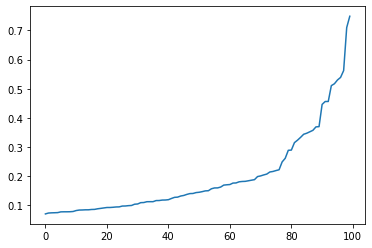

[ 657 1332  884  225 1093 1247  291  274  176  603 1001  590 1502  601
 1132  289 1243  257  330  529]
[1569  761  540  989  304 1066 1302 1065  718  335 1387 1487 1446 1175
 1391   90  993 1541 1110 1479]


In [24]:
study_specific_neurons()